# Simulations of a full cosmological volume

This tutorial will take you through the generation of a large-scale cosmological simulation and some analysis of its outputs. You can run this tutorial only after you have followed successfully the instruction in the README. 


## 1. Generating initial conditions

Generating initial conditions for cosmological N-body simulations roughly boils down to distributing dark matter particles in space in such a way that their density field is statistically consistent with observations (constraints from the CMB, LSS...). This is not a trivial exercise, and different techniques exist (see the review by [Angulo & Hahn, 2022](https://ui.adsabs.harvard.edu/abs/2022LRCA....8....1A/abstract). Here, we will use the [MUSIC code](https://bitbucket.org/ohahn/music/src/master/) and its more recent evolution [monofonic](https://bitbucket.org/ohahn/monofonic/src/master/), which are both established standards in the field.  

Both codes require a configuration file which defines the cosmological model, the simulated volume, the particle mass, etc. 

### 1.1. setting up MUSIC's parameter file

Open the file `MyFirstCosmoSim/ICs/music.conf` file with your favourite editor to have a look at the parameters. Parameters are defined in 5 sections as follows: 

1. Section `[setup]` defines the basic properties of the simulation. The following parameters are the ones we will vary in this tutorial.
```
boxlength = 400  # This is the side of the cubic volume in comoving Mpc/h (*mind the /h*)
levelmin  = 7    # This is minimum level of the grid. 
levelmax  = 7    # This should always be equal to levelmax in this tutorial. 
zstart    = 50   # This is the redshift at which the ICs are computed. 
baryons   = no   # Tick this flag if you want to have baryons in your simulation 
```
The parameters `levelmin` and `levelmax` (which should be equal here) define the number of DM particles in the simulation, that will be $N_p= (2^{l})^3$, where $l=$`levelmax`. Here, we have $l=7$ which means the simulation will contain $128^3$ DM particles, and the same number of coarse cells at initialisation. 

    The parameter `zstart` should be as small as possible so that density fluctuations are evolved linearly well above numerical noise, but as large as necessary so that no region in the box has departed from the linear regime yet... At very high resolution, tiny fluctuations will collapse very early on and `zstart` should be large. At low resolution, only more massive structures are resolved and they form later, so `zstart` can be larger.
    
    Other parameters of the `setup` section are described in the MUSIC documentation. 


2. Section `[cosmology]` defines the cosmological model. 

3. Section `[random]` provides seeds for the random number generation. These seeds basically define the *phase* of the density fluctuations, level by level. (See exercises in Sec. 5). 

4. Section `[output]` defines the outputs of MUSIC. As we are using RAMSES, this is more or less fixed as follows:
```
format      = grafic2	
filename    = ./
ramses_nml  = yes
```

    Here, the `filename` parameter actually defines the directory in which MUSIC will store the initial condition files. You should change this parameter if you wish to generate (and save) different sets of initial conditions.
    
    With `ramses_nml` parameter, MUSIC offers to generate part of a RAMSES configuration file.  


5. Section `[poisson]` define the methods used to evolve the density field to `zstart`. We will keep default values in this tutorial. 


### 1.2. Running MUSIC 
We can now run MUSIC to generate initial conditions. In a terminal type the following lines:
```
cd MyFirstCosmoSim/ICs
$MUSICDIR/MUSIC music.conf
```
This will run music with parameters from the file music.conf. As a result, MUSIC will create the directory  `level_007` that contains the following files:
`ic_deltab, ic_poscx, ic_poscy, ic_poscz, ic_velcx, ic_velcy, ic_velcz`. The files `ic_pos*` and `ic_vel*` contain the position and velocities of DM particles. Because we have set `ramses_nml = yes` in the configuration file, MUSIC also generates a RAMSES parameter file named `MyFirstCosmoSim/ICs/ramses.nml` that we will use below. 



## 2. RAMSES simulation

We will now use RAMSES to solve the non-linear Poisson equation. RAMSES also uses a parameter file, which is a *Fortran namelist* (see some brief intro to that [here](http://jules-lsm.github.io/vn4.2/namelists/intro.html)).


### 2.1. Setting up RAMSES parameters 

We provide an example namelist file here: `MyFirstCosmoSim/DarkMatterRun/ramses.nml`. Namelist files are again organised in sections that define parameters related to different parts of the code. (NB: these sections may be provided in any order in the file). The example file we provide has the following sections: 

1. `RUN_PARAMS`. This section defines some of the most basic properties of the run, and the importnat ones for us here are the following:
```
cosmo     = .true.  ! We are running a cosmological experiment. 
pic       = .true.  ! We are using a particle-in-cell algorithm to distribute particle mass into cells
poisson   = .true.  ! We wish to solve the Poisson equation
hydro     = .false. ! But not the hydro equations (we want DM only so far). 
```

2. `AMR_PARAMS`. This defines the global mesh properties and memory footprint of the code with the following parameters:
```
levelmin=7          ! this is the lowest level (same that in the initial conditions).
levelmax=15         ! This is the maximum level of refinement level allowed. 
nexpand=1           ! is the smoothing of the grid *I don't really know what this is!*
ngridtot=3000000     ! is the estimated max number of octs in the full volume 
nparttot=3000000     ! is the estimated max number of particles. 
```

3. `INIT_PARAMS` tells RAMSES where to look for initial condition files. 
```
filetype='grafic'               ! We are using the GRAFIC format
initfile(1)='../ICs/level_007'  ! relative path to the ICs we generated above. 
```

4. `OUTPUT_PARAMS` defines the output strategy. Here we will save two outputs at $z=0.5$ and $z=0$:
```
aout=0.5, 1.0
noutput=2
```

5. `REFINE_PARAMS` defines the refinement strategy. Here we implement a pseudo-Lagrangian refinement, were any cell with more than 8 particles is refined (into 8 cells).
```
m_refine=9*8.,
```
The syntax above says that we repeat the same criterion at all levels (7, 8, 9, 10, ... 14)


Note that the `ramses.nml` file that we provide in `MyFirstCosmoSim/DarkMatterRun/` is very similar to that produced by MUSIC (`MyFirstCosmoSim/ICs/ramses.nml`). The only difference is the `OUTPUT_PARAMS` that are not provided by MUSIC. 



### 2.2. Running RAMSES 

To run, type:
  ```
  cd MyFirstCosmoSim/DarkMatterRun
  $RAMSESDIR/bin/ramses3d ramses.nml 
  ```
  or, if you compiled with MPI and have 5 cores available: 
  ```
  cd MyFirstCosmoSim/DarkMatterRun
  mpirun -np 5 $RAMSESDIR/bin/ramses3d ramses.nml
  ```
  
This may take some time. When the run is complete, the directory `MyFirstCosmoSim/DarkMatterRun` will contain three new directories `output_00001` to `output_00003`. RAMSES outputs are numbered starting at 1 for the initial conditions. The directories `output_00002` and `output_00003` are the outputs we specified in the namelist file, and should be at $z=0.5$ and $z=0$. You can check this by looking at the information text file `output_*/info_*.txt`. For example, the following command 
```
grep aexp output_00003/info_00003.txt

```
will return `aexp =  0.100498362525257E+01` which is roughly at $z=0$. 


## 3. Data analysis out the output generated:
We will work in python and use (among others) [Pylians](https://pylians3.readthedocs.io/en/master/index.html) and [yt](https://yt-project.org/), to install them, some usefull information may be found  [here](https://pylians3.readthedocs.io/en/master/installation.html) and [here](https://yt-project.org/doc/installing.html).
We will now follow this  [notebook](./cosmology_ramses.ipynb) to analyse the data produced by the simulation.


In [1]:
import yt
yt.funcs.mylog.setLevel("ERROR")  ## stop yt from being to verbosy

import yt_astro_analysis
from yt.extensions.astro_analysis.halo_analysis import HaloCatalog

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 

import matplotlib
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams["figure.facecolor"]='w'
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

import numpy as np
import astropy.units as u
import f90nml # to load ramses data in yt

### 3.0. Load and explore the data with yt 

In [2]:
# load data from snapshot 3 (i.e. z ~ 0)
snap    = 3
snapstr = "%05d" % snap
path    = 'MyFirstCosmoSim/DarkMatterRun/'
ds      = yt.load(path+'output_'+snapstr+'/info_'+snapstr+'.txt')

In [3]:
#get some info on the simulation
ds.parameters;

In [4]:
# checkout the number of cells 
ds.print_stats()

level	       # cells	     # cells^3
--------------------------------------
  0	             0	             0
  1	             1	             1
  2	             8	             2
  3	            64	             4
  4	           512	             8
  5	          4096	            16
  6	         32768	            32
  7	        322872	            69
  8	        723547	            90
  9	        440961	            77
 10	        154507	            54
 11	         22331	            29
 12	           807	            10
 13	             0	             0
 14	             0	             0
 15	             0	             0
----------------------------------------------
   	       1702474


z = -0.00210806
t = 9.52342539e-01 code_time = 4.36158850e+17 s = 1.38210399e+10 yr

Smallest Cell:
	Width: 1.446e-01 Mpc
	Width: 1.446e+05 pc
	Width: 2.983e+10 AU
	Width: 4.463e+23 cm


In [5]:
# show fields contained in the data
for field in sorted(ds.field_list):
    print(field)

('all', 'particle_family')
('all', 'particle_identity')
('all', 'particle_level')
('all', 'particle_mass')
('all', 'particle_position_x')
('all', 'particle_position_y')
('all', 'particle_position_z')
('all', 'particle_tag')
('all', 'particle_velocity_x')
('all', 'particle_velocity_y')
('all', 'particle_velocity_z')
('gravity', 'Potential')
('gravity', 'x-acceleration')
('gravity', 'y-acceleration')
('gravity', 'z-acceleration')
('io', 'particle_family')
('io', 'particle_identity')
('io', 'particle_level')
('io', 'particle_mass')
('io', 'particle_position_x')
('io', 'particle_position_y')
('io', 'particle_position_z')
('io', 'particle_tag')
('io', 'particle_velocity_x')
('io', 'particle_velocity_y')
('io', 'particle_velocity_z')
('nbody', 'particle_family')
('nbody', 'particle_identity')
('nbody', 'particle_level')
('nbody', 'particle_mass')
('nbody', 'particle_position_x')
('nbody', 'particle_position_y')
('nbody', 'particle_position_z')
('nbody', 'particle_tag')
('nbody', 'particle_ve

In [6]:
#access data
ad = ds.all_data()
print(ad[('all', 'particle_position_x')].to('Mpc'))
print(ad[('gravity', 'Potential')])

[141.44510849   0.80506102   0.60554058 ... 299.20112922 299.06484763
 298.57166725] Mpc
[-0.00018843 -0.00010395 -0.00010752 ... -0.00075619 -0.00068147
 -0.00072077] code_velocity**2


### 3.1. Maps of the simulation volume

#### 3.1.1. We use yt's methods to display a projected mass map 


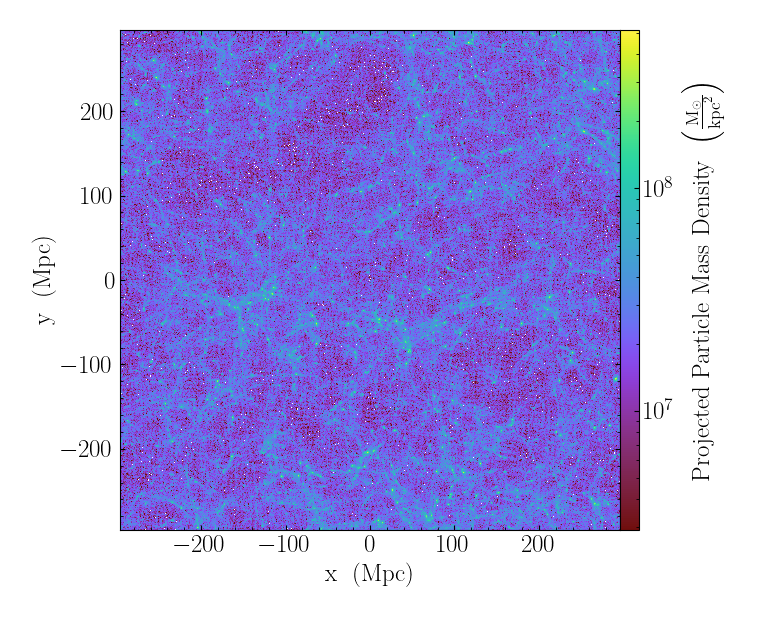

In [7]:
# plot the density map
p = yt.ParticlePlot(ds,'particle_position_x','particle_position_y','particle_mass',density=True)
p.set_figure_size((5,5))
p.set_buff_size(512)
p.set_unit('particle_mass', "Msun/kpc**2")
p.show()

#### 3.1.2. We construct the density map ourselves with numpy 

In [8]:
# extract coordinates and masses of particles 
px = ds.all_data()['particle_position_x'].to('Mpc').value
py = ds.all_data()['particle_position_y'].to('Mpc').value
pm = ds.all_data()['particle_mass'].to('Msun').value
# define the range of the image (in Mpc)
xmin = ds.domain_left_edge[0].to('Mpc').value
xmax = ds.domain_right_edge[0].to('Mpc').value
ymin = ds.domain_left_edge[1].to('Mpc').value
ymax = ds.domain_right_edge[1].to('Mpc').value
# define the resolution of the image (nb of pixels on a side)
npix = 512

# compute the mass in each pixel (2d histogram)
h,xe,ye = np.histogram2d(px,py,weights=pm,bins=(npix,npix),range=[[xmin,xmax],[ymin,ymax]])
# divide by area of pixels 
dx, dy = (xe[1]-xe[0])*1e3, (ye[1]-ye[0])*1e3 # [kpc]
h = h / dx / dy  # [Msun / kpc^2]

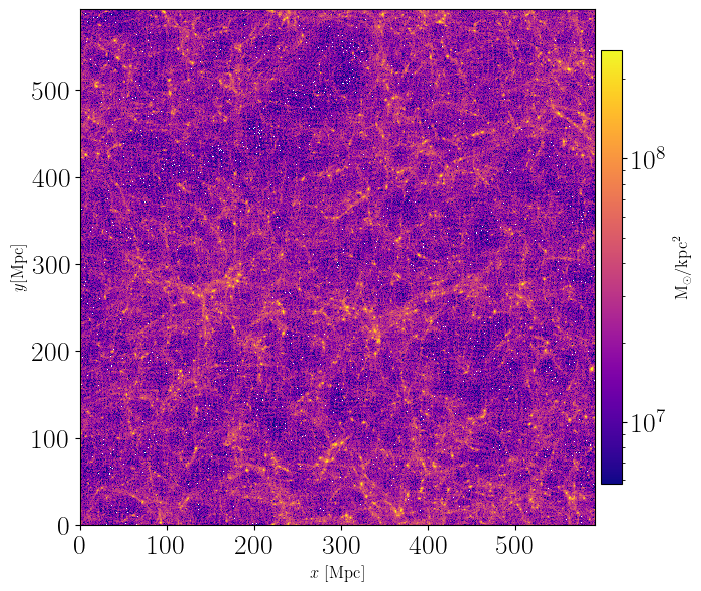

In [9]:
plt.figure(figsize=(7,7))
plt.imshow(h.T,origin='lower',norm=LogNorm(vmax=h.max()/2.,vmin=h[h>0].min()*2),interpolation='none',cmap='plasma',\
          extent=(xmin,xmax,ymin,ymax))
plt.xlabel(r'$x\ [{\rm Mpc}]$',fontsize=12)
plt.ylabel(r'$y [{\rm Mpc]}$',fontsize=12)
cb = plt.colorbar(location='right',fraction=0.04,pad=0.01)
cb.set_label(r'${\rm M}_\odot / {\rm kpc}^2$',fontsize=12)

#### 3.1.3. Map of the gravitational potential  [Does not work]

In [11]:
#q1 = yt.SlicePlot(ds, "z",('gravity', 'Potential'), width=(10,'Mpc'),center=[0.5, 0.5, 0.5])
#q1.annotate_cell_edges()
#q1.annotate_streamlines(('particle_velocity_x'), ('particle_velocity_y'))
#q1.show()

### 3.2. Dark matter halos 

#### 3.2.1. Halo detection 
For simplicity we will use the friends-of-friends (FOF) algorithm implemented in yt_astro_analysis. NB: The cell below actually runs the halo detection and may take time. If this has run once, you may skip the loading the halos one cell below. 

In [12]:
# identify Halos with yt's FOF halo finder. 
hc   = HaloCatalog(data_ds=ds, finder_method='fof', output_dir='MyFirstCosmoSim/DarkMatterRun/Halos')
hc.create()

The cell above should have created a halo catalog file `MyFirstCosmoSim/DarkMatterRun/Halos/info_00003/info_00003.0.h5`. We now load this file and overplot halos on the DM density map.

In [13]:
# we now load the halo catalog
hds = yt.load('MyFirstCosmoSim/DarkMatterRun/Halos/info_%5.5i/info_%5.5i.0.h5'%(snap,snap))
hc  = HaloCatalog(data_ds=ds,halos_ds=hds)


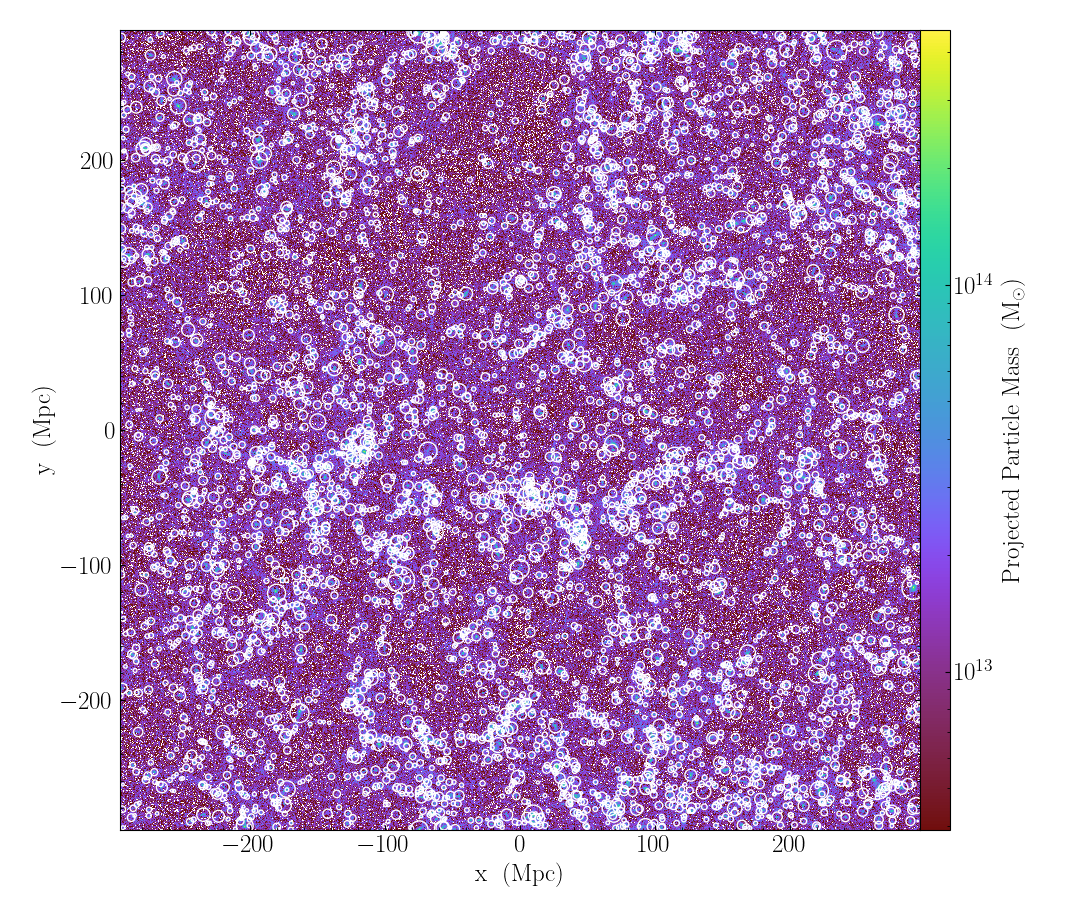

In [14]:
# and plot halos as circles on top of a mass map
p = yt.ParticlePlot(ds,'particle_position_x','particle_position_y','particle_mass')
p.set_unit('particle_mass', 'Msun')
p.annotate_halos(hc)

#### 3.2.2. Make a density map of the most massive halo 


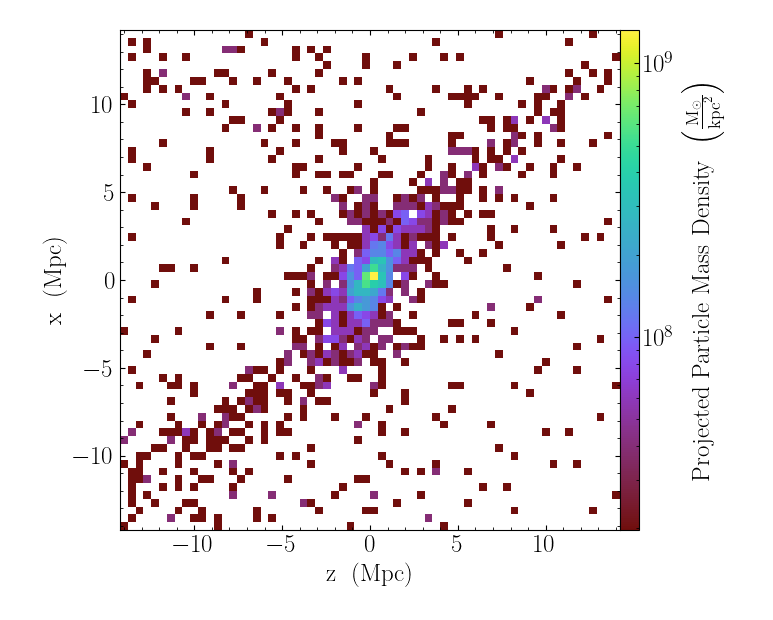

In [15]:
ad    = hds.all_data()
# select most massive halo 
haloM = ad["halos", "particle_mass"].to("Msun")
maxHaloID = np.where(haloM == haloM.max())[0][0]
halo = hds.halo("halos", maxHaloID)
center_halo=ad["halos", "particle_position"][maxHaloID]
rvir = 4 * ad["halos","virial_radius"][maxHaloID]  
p = yt.ParticlePlot(ds,'particle_position_x','particle_position_z','particle_mass',
                       center=center_halo,width=rvir,depth=rvir,axes_unit='Mpc',density=True) 
p.set_unit('particle_mass', "Msun/kpc**2")
p.set_buff_size(64)
p.set_figure_size((5,5))
p.show()

#### 3.2.3. Compute/plot the distribution of spin paramters 

**To be tested and improved (e.g. compute the actuall spin parameter)**

In [18]:
# **Clément** I have this, but I am not tested it much, so I don't garantee 
# **Jeremy** : please do... 
#spin=ad[('all', 'particle_angular_momentum_magnitude')]
#maax=np.amax(spin)
#bibi=np.logspace(np.log10(maax)-2.5,np.log10(maax),30)
 
# Creating histogram
#fig, ax = plt.subplots(figsize =(10, 7))
#ax.hist(spin, bins = bibi,alpha=0.3)
#plt.loglog()

#### 3.2.4 Halo mass function

In [19]:
# extract halo masses (in Msun units)
halo_masses = hc.halos_ds.all_data()['particle_mass'].to('Msun')

In [20]:
# Compute the simulation volume in comoving Mpc
SimVolume_proper = ds.domain_width[0].to('Mpc')**3
SimVolume_comov  = SimVolume_proper / ds.parameters['aexp']**3 

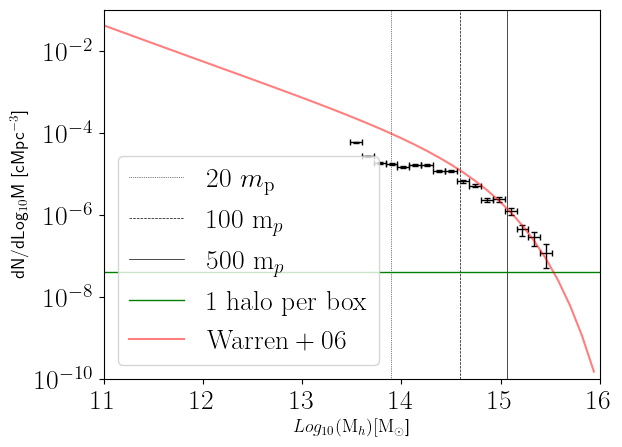

In [21]:
# Compute the mass function
h,xe = np.histogram(np.log10(halo_masses),bins=50,range=(10,16))
xmid = 0.5*(xe[:-1]+xe[1:]) # center of bins [Msun]
dh   = np.sqrt(h) # Poisson noise
normalisation = 1. / SimVolume_comov.value / (xmid[1]-xmid[0])
h    = h * normalisation   # nb of halos per cMpc^3 per dLogM
dh   = dh * normalisation 

# plot the HMF with Poisson error bars
plt.errorbar(xmid,h,yerr=dh,xerr=0.5*(xmid[1]-xmid[0]),elinewidth=1,capsize=2,
             ecolor='k',linestyle='none')
# add vertical lines marking 20,100, and 500 times the particle mass in the simulation
plt.axvline(np.log10(20*ds.all_data()['particle_mass'][0].to('Msun')),ls=':',c='k',lw=0.5,label=r'$20\ m_{\rm p}$')
plt.axvline(np.log10(100*ds.all_data()['particle_mass'][0].to('Msun')),ls='--',c='k',lw=0.5,label=r'$100\ {\rm m}_p$')
plt.axvline(np.log10(300*ds.all_data()['particle_mass'][0].to('Msun')),ls='-',c='k',lw=0.5,label=r'$500\ {\rm m}_p$')
# add a horizontal line marking the density corresponding to 1 halo in the simulation
plt.axhline(normalisation,color='g',lw=1,ls='-',label=r'${\rm 1\ halo\ per\ box}$') # ** Clément: does it mean we have one halo per box ??

#add a second axis to show the number of particles, not working yet
#fig, ax = plt.subplots()
#def Mtomp(x):
#    return x/(ds.all_data()['particle_mass'][0].to('Msun'))
#secax = ax.secondary_xaxis('top', functions=(Mtomp, Mtomp))
#secax.set_xlabel(r'${\rm nombre\ de\ particules}$')

# make the plot pretty
plt.xlim(11,16)
plt.ylim(1e-10,1e-1)
plt.xlabel(r'$ Log_{10} ({\rm M}_h) [ {\rm M}_\odot$]',fontsize=13)
plt.ylabel(r'dN/dLog$_{10}$M [cMpc$^{-3}$]',fontsize=13)
plt.yscale('log')

# Add models from Collossus 
from colossus.lss import mass_function
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')
little_h = cosmology.current_cosmo.H0/100.
redshift = ds.current_redshift
HMF_T = mass_function.massFunction(10.**xmid*little_h, redshift, mdef = 'fof', model = 'warren06',q_out = 'dndlnM')
plt.plot(xmid, HMF_T,label=r"${\rm Warren+06}$",c='r',alpha=0.5)
hush  = plt.legend()

Notice on the plot above how the simulation deviates from theoretical expectations (or actually fits from higher-resolution simulations) at low masses. Halos with less than a few 100 particles are affected by resolution and their population is incomplete, which leads to a systematic under-estimation of the halo mass function. 

### 3.3. Power spectrum [To fix]

**Clément** : if you want more diagnosis, I can also add a void finder (included in Pylians), measure of halo bias bispectrum, RSD (Pylians), I have routine to look at density profiles, halo concentration (and much more, but those are the easy ones which pops to my mind) 

In [ ]:
grid              = ds.domain_dimensions[0]    #grid size
pBoxSize           = ds.domain_width.in_units('Mpc/h') #Mpc/h
BoxSize            =pBoxSize[0].value #Mpc/h
Rayleigh_sampling = 1     #whether sampling the Rayleigh distribution for modes amplitudes
threads           = 1      #number of openmp threads
verbose           = True   #whether to print some information
axis=0
MAS='CIC'

In [ ]:
pos = ad['particle_position'].astype(np.float32)*BoxSize

# define 3D density fields
delta = np.zeros((grid,grid,grid), dtype=np.float32)

# construct 3D density field
MASL.MA(pos.astype(np.float32), delta, BoxSize, MAS, verbose=verbose)

# at this point, delta contains the effective number of particles in each voxel
# now compute overdensity and density constrast
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0


In [ ]:
Pk = PKL.Pk(delta, BoxSize, axis, 'None', threads, verbose)
k       = Pk.k3D
Pk0     = Pk.Pk[:,0]

plt.loglog(k,Pk0,label="RAMSES") #plot measure from N-body

toL=np.transpose(np.loadtxt("CLASS.dat"))
plt.loglog(toL[0],toL[1],linestyle="dotted",label='CLASS') #plot linear CLASS
toL=np.transpose(np.loadtxt("CLASS_NL.dat"))
plt.loglog(toL[0],toL[1],linestyle="dashdot",label='CLASS_NL') #plot non-linear CLASS from HaloFit

plt.legend()
plt.xlabel("k [h/Mpc]")
plt.ylabel(r"P(k) [$(Mpc/h)^3$]")
plt.show()

## 4. More fun. 

Here we suggest exercises to explore various aspects of cosmological simulations. 

1. **Cosmic variance**. Run simulations on ICs generated with different seeds. Measure the halo mass function and see how it changes. 

2. **Random seeds**. It is also instructive to run simulations which share the same realisation of density fluctuations on large scales, but that differ on small scales. This can be done easily with MUSIC's `[random]` section in the configuration file. Try generating ICs with seed[7]=12345, and different values for seed[8] (and higher). Run the simulations and discuss. (**Clément** : je connaissais pas...)

3. **Resolution effects**. The mass resolution (particle mass) has a strong impact on the population of DM halos that form in a simulation. While it is not practical to increase the number of particles here, we can instead change the volume of the simulation to probe this effect. Run simulations with a fixed number of particles and different volumes. Plot the halo mass functions to compare them. 

4. **DM concentration**. Dark matter is dissipationless and will thus not condense into arbitrary large densities. You can see this by running RAMSES simulations with different values of `levelmax`. Try a very large value (e.g. 20) and see if the simulation reaches that. Careful, though, if you turn on dissipative hydro, the gas *will* collapse as far as you allow. 

5. **ngridmax and ngridtot** ... Should we explore these things ?  I would only mention it but not explore

6. **Adding gas...** Run an adiabatic simulation with gas. And one with cooling turned on (but no SF?). 
